In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf

os.environ['JAX_PLATFORM_NAME'] = 'gpu'

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)



# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-10-25 12:36:24.435834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 12:36:24.453334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 12:36:24.458604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 12:36:25.703146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the CMIP6 data to the GMFD resolution (e.g., ~25 km) to use as the target during training.

In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


# Normalize the data (standardization)
def normalize(data):
    mean = data.mean().compute().item()
    std = data.std().compute().item()
    return (data - mean) / std

cmip6_data_norm = normalize(cmip6_high_res['tas'])
gmfd_data_norm = normalize(gmfd_data['tas'])

# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
gmfd_train = gmfd_data_norm.values

#### Split the data
Train set: The first portion of the time period (e.g., 60-70% of the time series).
Validation set: The next portion of the time series (e.g., the following 15-20% of the time series).
Test set: The final portion of the time series (e.g., the last 15-20%): 

In [3]:
# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
gmfd_train_reshaped = gmfd_train[..., np.newaxis]

# Get the total number of time steps
n_samples = cmip6_train_reshaped.shape[0]

# Split indices based on time series order
train_size = int(n_samples * 0.6)  # 60% for training
val_size = int(n_samples * 0.2)    # 20% for validation
test_size = n_samples - train_size - val_size  # Remainder for test


# Split the data while preserving the temporal structure
X_train = cmip6_train_reshaped[:train_size]
y_train = gmfd_train_reshaped[:train_size]

X_val = cmip6_train_reshaped[train_size:train_size + val_size]
y_val = gmfd_train_reshaped[train_size:train_size + val_size]

X_test = cmip6_train_reshaped[train_size + val_size:]
y_test = gmfd_train_reshaped[train_size + val_size:]

(14244, 42, 97, 1)
(14244, 42, 97, 1)
(4748, 42, 97, 1)
(4748, 42, 97, 1)
(4749, 42, 97, 1)
(4749, 42, 97, 1)


#### Build the U-Net


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def climate_unet(input_shape=(42, 97, 1), n_filters=64):
    """U-Net adapted for climate downscaling with additional features."""
    
    inputs = keras.Input(shape=input_shape)
    
    # Initial processing
    x = layers.BatchNormalization()(inputs)
    
    # Encoder
    # Block 1
    conv1 = layers.Conv2D(n_filters, 3, activation='leaky_relu', padding='same')(x)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(n_filters, 3, activation='leaky_relu', padding='same')(conv1)
    conv1 = layers.SpatialDropout2D(0.1)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = layers.Conv2D(n_filters*2, 3, activation='leaky_relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(n_filters*2, 3, activation='leaky_relu', padding='same')(conv2)
    conv2 = layers.SpatialDropout2D(0.1)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Middle block
    conv3 = layers.Conv2D(n_filters*4, 3, activation='leaky_relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(n_filters*4, 3, activation='leaky_relu', padding='same')(conv3)
    conv3 = layers.SpatialDropout2D(0.2)(conv3)
    
    # Decoder
    # Block 4
    up4 = layers.Conv2DTranspose(n_filters*2, 2, strides=2, padding='same')(conv3)
    padding_h = conv2.shape[1] - up4.shape[1]
    padding_w = conv2.shape[2] - up4.shape[2]
    if padding_h > 0 or padding_w > 0:
        up4 = layers.ZeroPadding2D(padding=((0, padding_h), (0, padding_w)))(up4)
    concat4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(n_filters*2, 3, activation='leaky_relu', padding='same')(concat4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(n_filters*2, 3, activation='leaky_relu', padding='same')(conv4)
    
    # Block 5
    up5 = layers.Conv2DTranspose(n_filters, 2, strides=2, padding='same')(conv4)
    padding_h = conv1.shape[1] - up5.shape[1]
    padding_w = conv1.shape[2] - up5.shape[2]
    if padding_h > 0 or padding_w > 0:
        up5 = layers.ZeroPadding2D(padding=((0, padding_h), (0, padding_w)))(up5)
    concat5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(n_filters, 3, activation='leaky_relu', padding='same')(concat5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(n_filters, 3, activation='leaky_relu', padding='same')(conv5)
    
    # Output layer
    outputs = layers.Conv2D(1, 1, activation='linear', padding='same')(conv5)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (42, 97, 1)
model = climate_unet(input_shape)

# Print model summary
#model.summary()

#### Train the model

Epoch 1/1500
446/446 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 3.1433 - mse: 3.1433 - val_loss: 0.3500 - val_mse: 0.3500 - learning_rate: 0.0100
Epoch 2/1500
446/446 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.3560 - mse: 0.3560 - val_loss: 0.3218 - val_mse: 0.3218 - learning_rate: 0.0100
Epoch 3/1500
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.3425 - mse: 0.3425 - val_loss: 0.3313 - val_mse: 0.3313 - learning_rate: 0.0100
Epoch 4/1500
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.3343 - mse: 0.3343 - val_loss: 0.3203 - val_mse: 0.3203 - learning_rate: 0.0100
Epoch 5/1500
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.3377 - mse: 0.3377 - val_loss: 0.3296 - val_mse: 0.3296 - learning_rate: 0.0100
Epoch 6/1500
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.3302 - mse: 0.3302 - val_loss: 0.3282 - val_mse: 0.3282 - learning_rate: 0.0100
Epoch 7/1500
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.3375 - mse: 0.3375 - val_loss: 0.3116 - val_mse: 0.3116 - learni

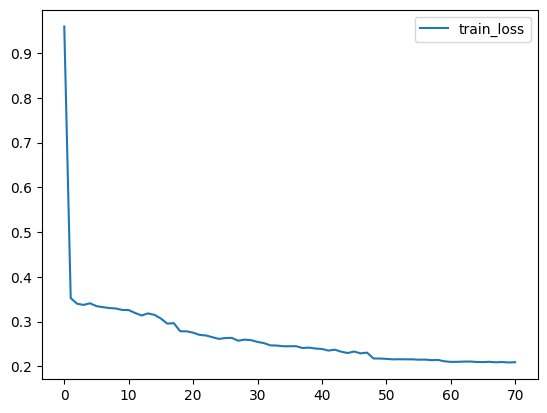

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


# Compile with custom loss
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, 
             loss='mse',
             metrics=['mse'])

# Add callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    ),
    keras.callbacks.ModelCheckpoint(
        'models/unet_best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1500,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)




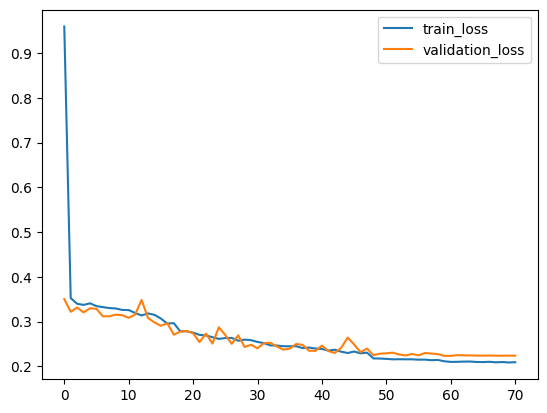

In [9]:
# Plot the training loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

#### Evaluate the model on validation data

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


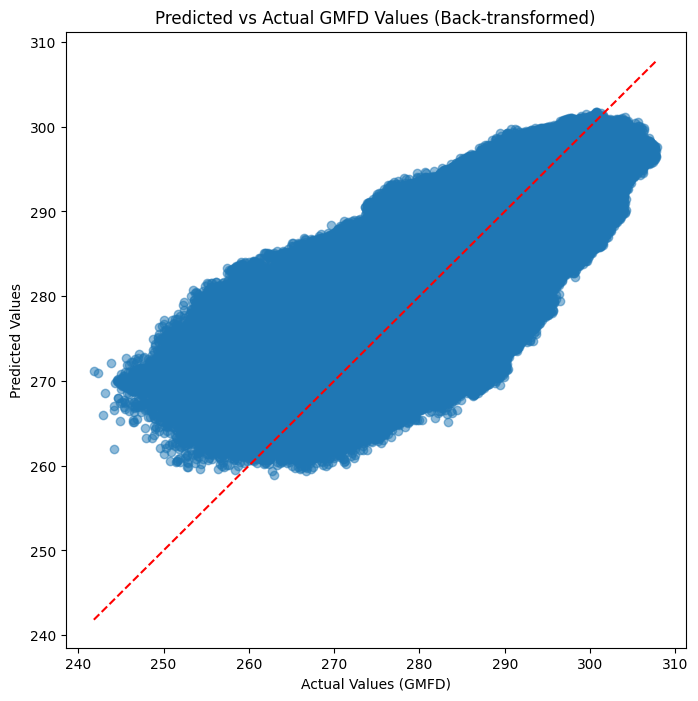

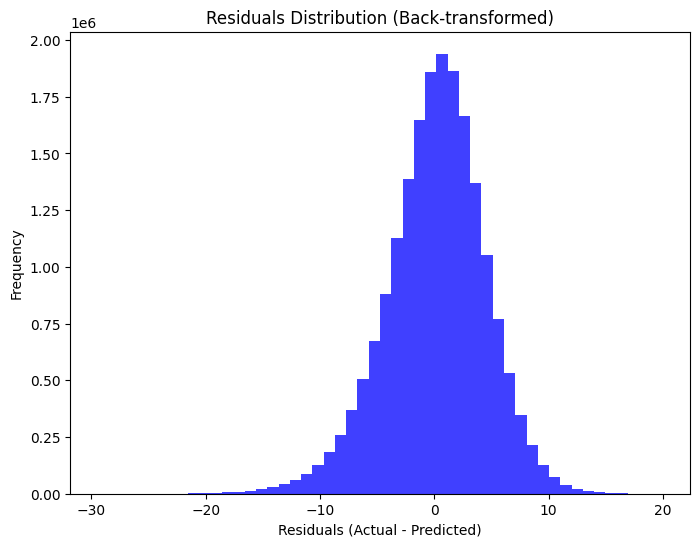

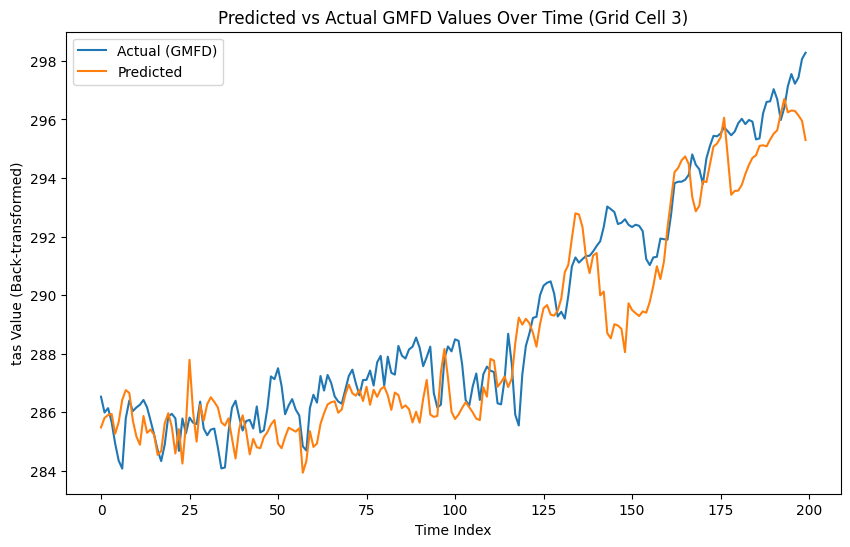

In [10]:
import numpy as np

# Back-transform function
def denormalize(data, mean, std):
    return (data * std) + mean

# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values

# Get the mean and std from the training set for denormalization
gmfd_mean = gmfd_data['tas'].mean().values
gmfd_std = gmfd_data['tas'].std().values

# # Evaluate on the denormalized test data
# val_mse, val_mae = model.evaluate(X_test, y_test, verbose=1)
# print(f"Validation MAE: {val_mae}")
# print(f"Validation MSE: {val_mse}")


# Generate predictions on validation data
y_pred = model.predict(X_val)


# Back-transform the predictions for evaluation
y_val_denorm = denormalize(y_val, cmip6_high_res_mean, cmip6_high_res_std)
y_pred_denorm = denormalize(y_pred, cmip6_high_res_mean, cmip6_high_res_std)

# Plot: Predicted vs Actual Values (back-transformed)
plt.figure(figsize=(8, 8))
plt.scatter(y_val_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_val_denorm.min(), y_val_denorm.max()], [y_val_denorm.min(), y_val_denorm.max()], 'r--')  # Line of perfect prediction
plt.show()

# Plot: Residuals (Actual - Predicted) after back-transform
residuals_denorm = y_val_denorm.flatten() - y_pred_denorm.flatten()
plt.figure(figsize=(8, 6))
plt.hist(residuals_denorm, bins=50, alpha=0.75, color='blue')
plt.title('Residuals Distribution (Back-transformed)')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# Plot: Predicted and Actual Values Over Time for a Specific Grid Cell (Back-transformed)
# Select a grid cell (e.g., the first one)
grid_cell_index = 3
plt.figure(figsize=(10, 6))
plt.plot(y_val_denorm[:200, grid_cell_index, 0].flatten(), label='Actual (GMFD)')
plt.plot(y_pred_denorm[:200, grid_cell_index, 0].flatten(), label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('tas Value (Back-transformed)')
plt.title(f'Predicted vs Actual GMFD Values Over Time (Grid Cell {grid_cell_index})')
plt.legend()
plt.show()


#### Train the Best Model on All Data
Train the model on all the data (no splitting)

Epoch 1/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.2343 - mse: 0.2343 - val_loss: 0.2277 - val_mse: 0.2277 - learning_rate: 0.0100
Epoch 2/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.2340 - mse: 0.2340 - val_loss: 0.2311 - val_mse: 0.2311 - learning_rate: 0.0100
Epoch 3/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2321 - mse: 0.2321 - val_loss: 0.2254 - val_mse: 0.2254 - learning_rate: 0.0100
Epoch 4/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2317 - mse: 0.2317 - val_loss: 0.2277 - val_mse: 0.2277 - learning_rate: 0.0100
Epoch 5/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2356 - mse: 0.2356 - val_loss: 0.2245 - val_mse: 0.2245 - learning_rate: 0.0100
Epoch 6/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2297 - mse: 0.2297 - val_loss: 0.2201 - val_mse: 0.2201 - learning_rate: 0.0100
Epoch 7/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2281 - mse: 0.2281 - val_loss: 0.2247 - val_mse: 0.2247 - 

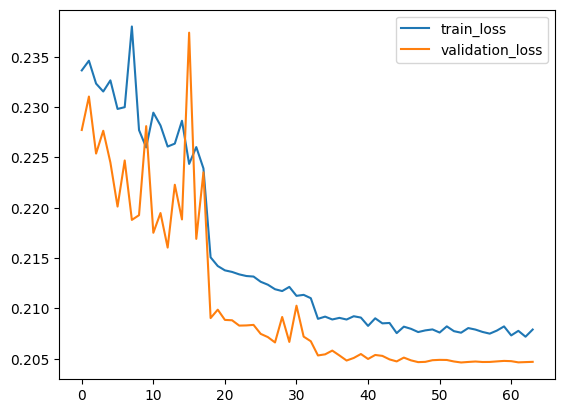

In [12]:
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)
model = climate_unet(input_shape)
# Compile with custom loss
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, 
             loss='mse',
             metrics=['mse'])


# Training the model
history = model.fit(
    cmip6_train_reshaped, gmfd_train_reshaped,
    validation_data=(X_val, y_val),
    epochs=1500,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

model.save('models/unet_CNRM-ESM2-1.keras')  # keras format


# Plot the training loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

#### Apply the Model to CMIP6 Data to Downscale to GMFD Original Resolution
Now we take the coarse CMIP6 data and downscale it to the original GMFD resolution


In [13]:
# Load the model
from keras.models import load_model
#model = load_model('models/cnn_encoder_decoder.keras')

# Predict downscaled high-resolution data
predicted_high_res = model.predict(cmip6_train_reshaped)

742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


#### Post-process the Predictions

In [14]:
# Inverse transform the predictions to get the actual temperature values


# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values


# Back-transform the predictions and actual values
predicted_high_res_denorm = denormalize(predicted_high_res, cmip6_high_res_mean, cmip6_high_res_std)

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/unet/predicted_high_res_tas_unet.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


#### Test on scenario